In [1]:
%matplotlib inline

from pathlib import Path

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pylab as plt
from dmba import classificationSummary, gainsChart, liftChart
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from dmba import plotDecisionTree, classificationSummary, regressionSummary

from sklearn import preprocessing
from sklearn.metrics import pairwise
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans
import matplotlib.pylab as plt
import seaborn as sns
from pandas.plotting import parallel_coordinates

# HOMEWORK 1

This homework is based on cardiac Single Proton Emission Computed Tomography and  was obtained from https://archive.ics.uci.edu/ml/datasets/spect+heart. Your goal is to predict the diagnosis of the patient. There are no missing variables.

__1__. Import and merge the SPECT.train and SPECT.test data sets. Create a single dataframe with appropriate column names (see link above) where the 'OVERALL_DIAGNOSIS' column is the outcome variable. Print the top 10 records of your dataframe.

In [10]:
X_train = pd.read_csv("SPECT.train",header=None)
X_test = pd.read_csv("SPECT.test",header=None)
cols1 = ['F'+str(i) for i in range (len(X_train.columns))]
cols2 = ['F'+str(i) for i in range (len(X_test.columns))]
X_train.columns = cols1
X_test.columns = cols2
data = pd.concat([X_train,X_test ])
data.head(10)

,F0,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22
0,1,0,0,0,1,0,0,0,1,1,...,1,1,0,0,0,0,0,0,0,0
1,1,0,0,1,1,0,0,0,1,1,...,1,1,0,0,0,0,0,0,0,1
2,1,1,0,1,0,1,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1
4,1,0,0,0,0,0,0,0,1,0,...,1,0,1,1,0,0,0,0,0,0
5,1,0,0,0,1,0,0,0,0,1,...,1,1,0,1,0,0,0,1,0,1
6,1,1,0,1,1,0,0,0,1,0,...,1,0,0,0,0,0,0,0,1,1
7,1,0,0,1,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,1
8,1,0,0,1,0,0,0,1,1,0,...,1,0,1,0,0,0,0,0,1,1
9,1,0,1,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0


__2__.  Partition the data into training (60%) and validation (40%) sets 

In [11]:
X = data.drop(columns=['F0'])
predictors = X.columns
y = data['F0']
outcome = y.name
classes = list(set(y))
# split into training and validation
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.4, random_state=1)

__3__. Run the Naïve Bayes algorithm, print your classification summary, and plot the related gains and lift charts.

In [12]:
# run naive Bayes
patient_nb = MultinomialNB(alpha=0.01)
patient_nb.fit(X_train, y_train)

# predict probabilities
predProb_train = patient_nb.predict_proba(X_train)
predProb_valid = patient_nb.predict_proba(X_valid)

# predict class membership
y_valid_pred = patient_nb.predict(X_valid)
y_train_pred = patient_nb.predict(X_train)

In [13]:
nb_result = pd.DataFrame({'actual': y_valid, 
                             'p(0)': [p[0] for p in predProb_valid],
                             'p(1)': [p[1] for p in predProb_valid],
                             'predicted': y_valid_pred})
nb_result = np.round(nb_result, 2)

In [14]:
classificationSummary(y_train, y_train_pred, class_names=classes)
print('----------------------------------------')
classificationSummary(y_valid, y_valid_pred, class_names=classes) 

Confusion Matrix (Accuracy 0.7500)

       Prediction
Actual   0   1
     0   7  27
     1  13 113
----------------------------------------
Confusion Matrix (Accuracy 0.7009)

       Prediction
Actual  0  1
     0  1 20
     1 12 74


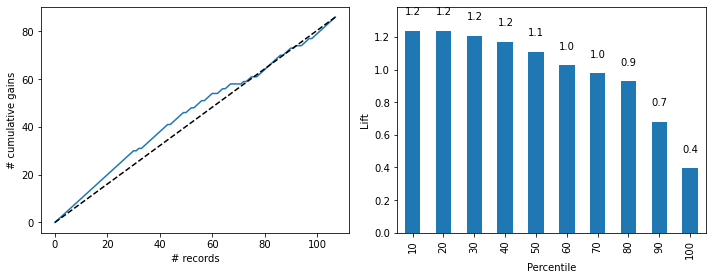

In [226]:
df = nb_result.sort_values(by=['p(1)'], ascending=False)
df = df.reset_index()
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

gainsChart(df.actual, ax=axes[0])
liftChart(df['p(1)'], title=False, ax=axes[1])
    
plt.tight_layout()
plt.show()

__4__. Run a decision tree classifier algorithm on the data and print your tree.  Re-run your analysis with a smaller tree where max_depth=30, min_samples_split=20, and min_impurity_decrease=0.01. Print the summaries of your classification.

Confusion Matrix (Accuracy 0.9437)

       Prediction
Actual   0   1
     0  33   1
     1   8 118
----------------------------------------
Confusion Matrix (Accuracy 0.7383)

       Prediction
Actual  0  1
     0 13  8
     1 20 66


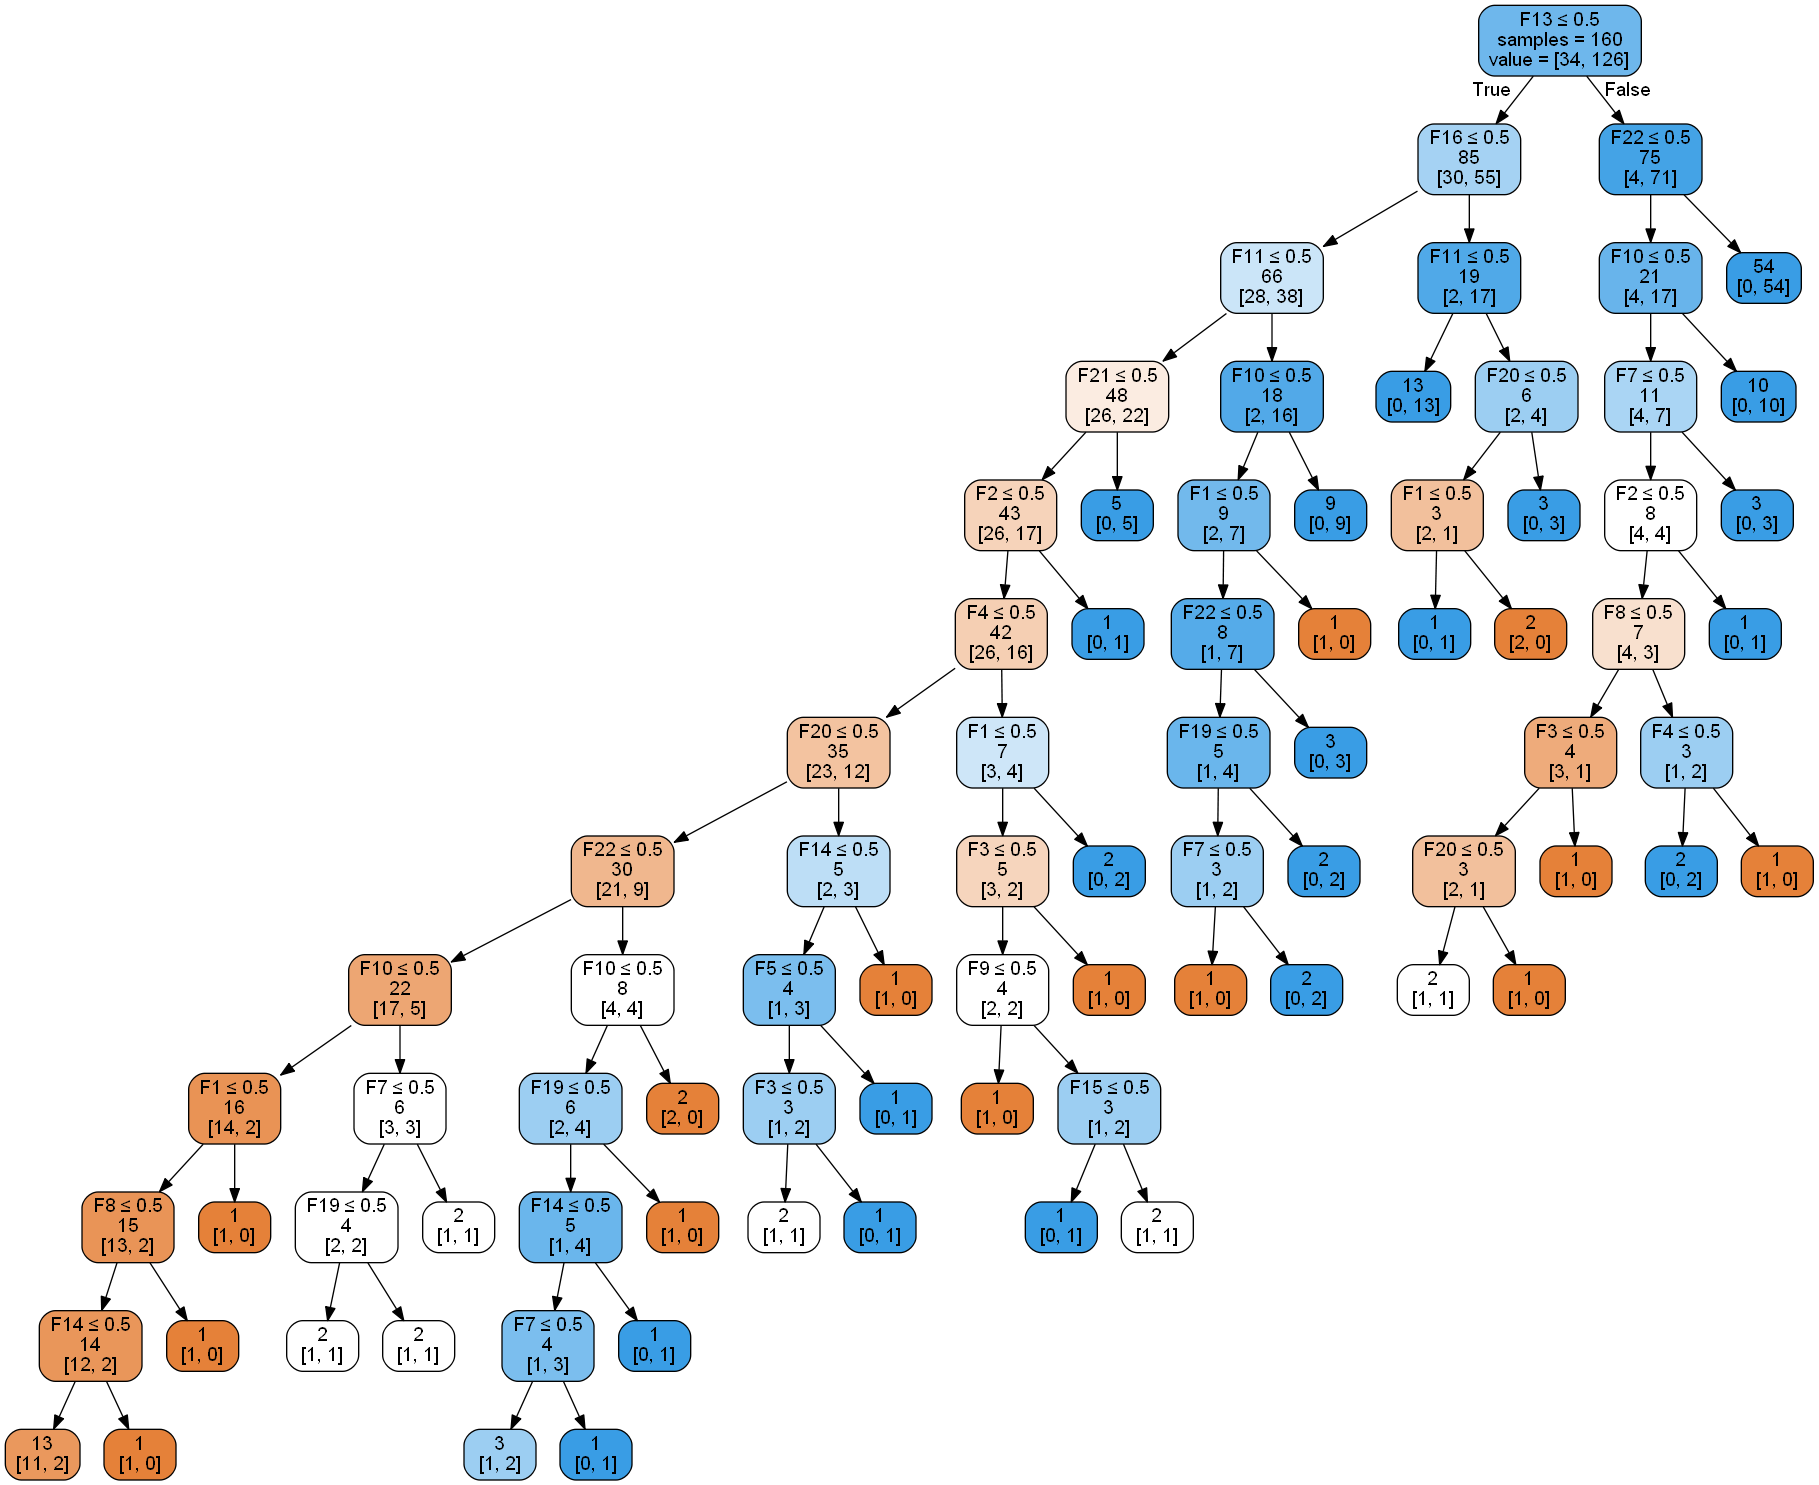

In [227]:
#full tree
fullClassTree = DecisionTreeClassifier()
fullClassTree.fit(X_train, y_train)

classificationSummary(y_train, fullClassTree.predict(X_train))
print('----------------------------------------')
classificationSummary(y_valid, fullClassTree.predict(X_valid))

plotDecisionTree(fullClassTree, feature_names=X_train.columns)


Confusion Matrix (Accuracy 0.8438)

       Prediction
Actual   0   1
     0  26   8
     1  17 109
----------------------------------------
Confusion Matrix (Accuracy 0.7944)

       Prediction
Actual  0  1
     0 16  5
     1 17 69


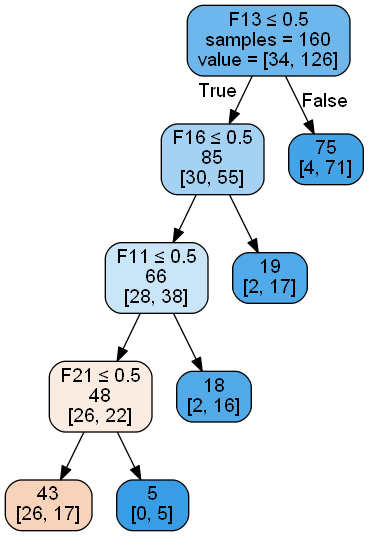

In [228]:
#smaller tree
smallClassTree = DecisionTreeClassifier(max_depth=30, min_samples_split=20, min_impurity_decrease=0.01)
smallClassTree.fit(X_train, y_train)

classificationSummary(y_train, smallClassTree.predict(X_train))
print('----------------------------------------')
classificationSummary(y_valid, smallClassTree.predict(X_valid))

plotDecisionTree(smallClassTree, feature_names=X_train.columns)


In [229]:
#random forest algorithm
rf = RandomForestClassifier(n_estimators=500, random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=500, random_state=1)

   feature  importance       std
17     F18    0.008549  0.016165
14     F15    0.013579  0.020883
16     F17    0.017221  0.024095
13     F14    0.027770  0.029073
5       F6    0.031613  0.032725
11     F12    0.031881  0.030543
4       F5    0.034273  0.035742
1       F2    0.035887  0.037139
8       F9    0.036068  0.030340
0       F1    0.037203  0.038236
2       F3    0.041481  0.035916
18     F19    0.042052  0.032321
10     F11    0.042616  0.041729
3       F4    0.044339  0.037241
9      F10    0.051495  0.046358
6       F7    0.053649  0.043359
7       F8    0.055508  0.047250
19     F20    0.062838  0.040835
15     F16    0.068303  0.042814
20     F21    0.076332  0.052766
12     F13    0.083193  0.061046
21     F22    0.104151  0.057423
----------------------------------------
Confusion Matrix (Accuracy 0.8598)

       Prediction
Actual  0  1
     0 13  8
     1  7 79
----------------------------------------


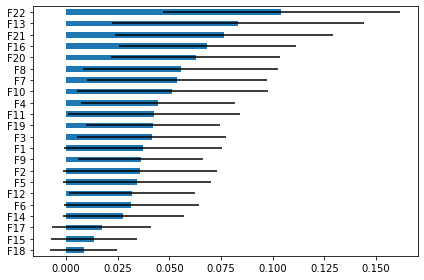

In [231]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

df = pd.DataFrame({'feature': X_train.columns, 'importance': importances, 'std': std})
df = df.sort_values('importance')
print(df)

ax = df.plot(kind='barh', xerr='std', x='feature', legend=False)
ax.set_ylabel('')
print('----------------------------------------')
classificationSummary(y_valid, rf.predict(X_valid))
print('----------------------------------------')
plt.tight_layout()
plt.show()

In [232]:
## boosted tree algorithm
boost = GradientBoostingClassifier()
boost.fit(X_train, y_train)
print('----------------------------------------')
classificationSummary(y_valid, boost.predict(X_valid))

----------------------------------------
Confusion Matrix (Accuracy 0.8598)

       Prediction
Actual  0  1
     0 13  8
     1  7 79


__6__. Run logistic regression on the data, print your classification summary, and plot the related gains and lift charts.

In [234]:
logit_reg = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
logit_reg.fit(train_X, train_y)
classificationSummary(train_y, logit_reg.predict(train_X))
classificationSummary(valid_y, logit_reg.predict(valid_X))

Confusion Matrix (Accuracy 0.8562)

       Prediction
Actual   0   1
     0  20  14
     1   9 117
Confusion Matrix (Accuracy 0.8411)

       Prediction
Actual  0  1
     0 14  7
     1 10 76


In [235]:
logit_reg_pred = logit_reg.predict(valid_X)
logit_reg_proba = logit_reg.predict_proba(valid_X)
logit_result = pd.DataFrame({'actual': valid_y, 
                             'p(0)': [p[0] for p in logit_reg_proba],
                             'p(1)': [p[1] for p in logit_reg_proba],
                             'predicted': logit_reg_pred })

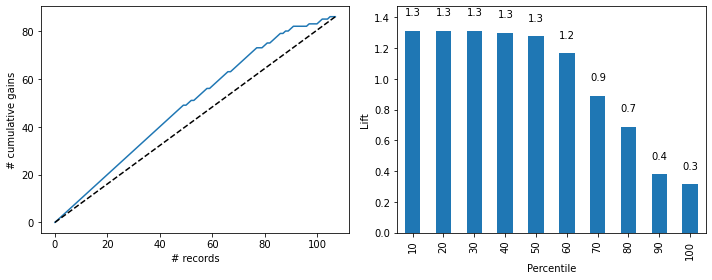

In [237]:
df = logit_result.sort_values(by=['p(1)'], ascending=False)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

gainsChart(df.actual, ax=axes[0])
liftChart(df['p(1)'], title=False, ax=axes[1])
    
plt.tight_layout()
plt.show()

__7__. Discuss your results. How do your results compare to the results from the CLIP3 algorithm mentioned in the link above? Discuss ways to improve your predictive accuracy. What are the advantages and disadvantages of each of the algorithms that you employed?

In all of these results, the Naïve Bayes (NB) algorithm seems to have the least predictive accuracy of 70%, which is expected since NB algorithms typically require a large number of training examples to produce high and stable predictions. The full tree classification shows a slightly better predictive accuracy of 74%. The smaller tree does a better job with a 79% accuracy rate. Both the random forest and boosted tree algorithms have the best accuracy of 86%, an accuracy rate that is slightly better than that of the CLEP3 algorithm (84%). The accuracy of logistic regression seems to similar to that of ClEP3  algorithm. For ways to improve accuracy and advantages/disadvantages of the algorithms above, see the discussion in the textbook.

# HOMEWORK 2

An equities analyst is studying the pharmaceutical industry and would like your help in exploring and
understanding the financial data collected by her firm. Her main objective is to understand the structure of the pharmaceutical industry using some basic financial measures.

Financial data gathered on 21 firms in the pharmaceutical industry are available in the file _Pharmaceuticals.csv_. For each firm, the following variables are recorded:

1. Market capitalization (in billions of dollars)
2. Beta
3. Price/earnings ratio
4. Return on equity
5. Return on assets
6. Asset turnover
7. Leverage
8. Estimated revenue growth
9. Net profit margin
10. Median recommendation (across major brokerages)
11. Location of firm's headquarters
12. Stock exchange on which the firm is listed


Use cluster analysis to explore and analyze the given dataset as follows:

__1__. Load the Pharmaceuticals.csv data set, make Symbol the index, drop non-numerical variables, and normalize your data. Print the head of your dataframe.

In [200]:
# Load data, use the column Company as row names
pharma_df = pd.read_csv('Pharmaceuticals.csv')
pharma_df.set_index('Symbol', inplace=True)
pharma_data = pharma_df.drop(columns=['Name', 'Median_Recommendation', 'Location', 'Exchange'])
pharma_norm = pharma_data.apply(preprocessing.scale, axis=0)
#pharma_norm = pharma_norm.sample(frac=0.95) to check the stability of the results
pharma_data.head()

,Market_Cap,Beta,PE_Ratio,ROE,ROA,Asset_Turnover,Leverage,Rev_Growth,Net_Profit_Margin
Symbol,,,,,,,,,
ABT,68.44,0.32,24.7,26.4,11.8,0.7,0.42,7.54,16.1
AGN,7.58,0.41,82.5,12.9,5.5,0.9,0.60,9.16,5.5
AHM,6.30,0.46,20.7,14.9,7.8,0.9,0.27,7.05,11.2
AZN,67.63,0.52,21.5,27.4,15.4,0.9,0.00,15.00,18.0
AVE,47.16,0.32,20.1,21.8,7.5,0.6,0.34,26.81,12.9


__2__. Run the average linkage algorithm on your dataframe, generate a related dendrogram (color_threshold=3.9), and print your cluster membership (4 clusters).

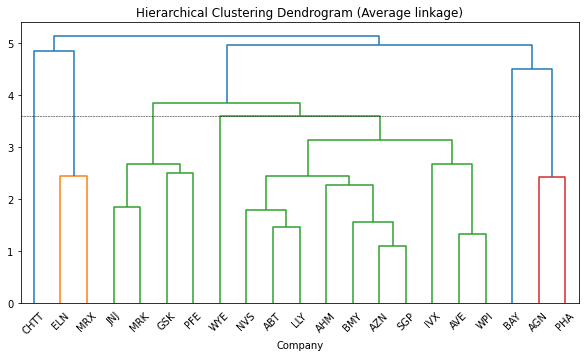

In [186]:
Z = linkage(pharma_norm, method='average')

fig = plt.figure(figsize=(10, 6))
fig.subplots_adjust(bottom=0.23)
plt.title('Hierarchical Clustering Dendrogram (Average linkage)')
plt.xlabel('Company')
dendrogram(Z, labels=list(pharma_norm.index), color_threshold=3.9)
plt.axhline(y=3.6, color='black', linewidth=0.5, linestyle='dashed')
plt.show()

In [187]:
memb = fcluster(linkage(pharma_norm, 'average'), 4, criterion='maxclust')
memb = pd.Series(memb, index=pharma_norm.index)
for key, item in memb.groupby(memb):
    print(key, ': ', ', '.join(item.index))

1 :  ELN, MRX
2 :  CHTT
3 :  ABT, AHM, AZN, AVE, BMY, LLY, GSK, IVX, JNJ, MRK, NVS, PFE, SGP, WPI, WYE
4 :  AGN, BAY, PHA


__3__. Print a clustermap by setting labels as cluster membership and company name.

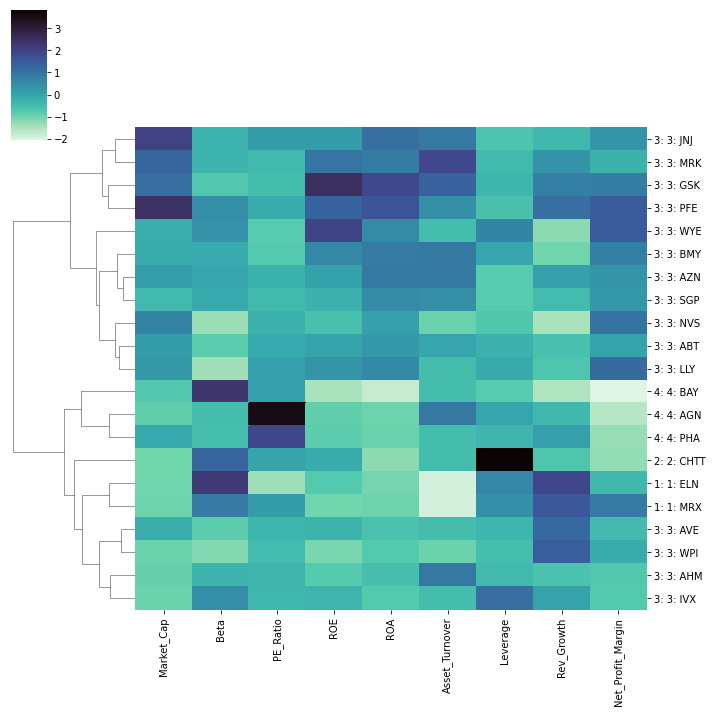

In [189]:
pharma_norm.index = ['{}: {}'.format(cluster, state) for cluster, state in zip(memb, pharma_norm.index)]
sns.clustermap(pharma_norm, method='ward', col_cluster=False,  cmap="mako_r")
plt.show()

__4__. Run k-means clustering algorithm (use the elbow chart to determine the best number of clusters) and determine and plot the centroids. Also, print the cluster membership, the within-cluster sum of squared distances( including the cluster count), and Euclidian distance between cluster centroids.

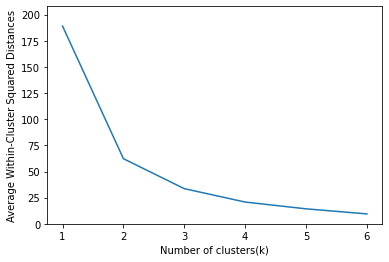

In [201]:
# k-means clustering
inertia = []
for n_clusters in range(1, 7):
    kmeans = KMeans(n_clusters=n_clusters, random_state=1).fit(pharma_norm)
    inertia.append(kmeans.inertia_ / n_clusters)
inertias = pd.DataFrame({'n_clusters': range(1, 7), 'inertia': inertia})
ax = inertias.plot(x='n_clusters', y='inertia')
plt.xlabel('Number of clusters(k)')
plt.ylabel('Average Within-Cluster Squared Distances')
plt.ylim((0, 1.1 * inertias.inertia.max()))
ax.legend().set_visible(False)
plt.show()

In [202]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(pharma_norm)

,Market_Cap,Beta,PE_Ratio,ROE,ROA,Asset_Turnover,Leverage,Rev_Growth,Net_Profit_Margin,cluster
0,-0.139209,-0.553632,-0.338119,0.026815,0.205215,-2.950021e-16,-0.307830,-0.305966,0.403623,Cluster 1
1,-0.986244,1.224434,-0.372987,-0.532913,-0.984813,-1.181641e+00,1.513856,0.729595,-0.377932,Cluster 2
2,-0.537584,0.456134,1.895526,-1.066149,-1.215887,-3.357103e-16,-0.352858,-0.591193,-1.649292,Cluster 3
3,1.737454,-0.182453,-0.203359,1.265486,1.383690,1.181641e+00,-0.479637,0.478716,0.605843,Cluster 4


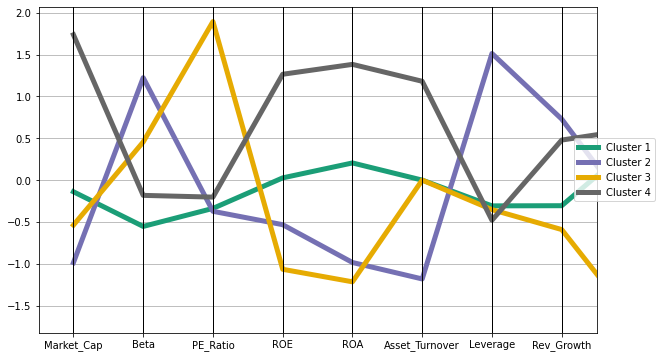

In [206]:
#Plot of centroid
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=pharma_norm.columns)
centroids['cluster'] = ['Cluster {}'.format(i+1) for i in centroids.index]

plt.figure(figsize=(10,6))
fig.subplots_adjust(right=3)
ax = parallel_coordinates(centroids, class_column='cluster', colormap='Dark2', linewidth=5)
plt.legend(loc='center left', bbox_to_anchor=(0.95, 0.5))
plt.xlim(-0.5,7.5)
centroids

In [219]:
centroids.describe()

,Market_Cap,Beta,PE_Ratio,ROE,ROA,Asset_Turnover,Leverage,Rev_Growth,Net_Profit_Margin
count,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000e+00,4.000000,4.000000,4.000000
mean,0.018604,0.236120,0.245265,-0.076690,-0.152949,-2.775558e-16,0.093383,0.077788,-0.254439
std,1.196998,0.779761,1.102603,0.999886,1.198801,9.648062e-01,0.949771,0.627269,1.022089
min,-0.986244,-0.553632,-0.372987,-1.066149,-1.215887,-1.181641e+00,-0.479637,-0.591193,-1.649292
25%,-0.649749,-0.275248,-0.346836,-0.666222,-1.042581,-2.954104e-01,-0.384553,-0.377273,-0.695772
50%,-0.338396,0.136840,-0.270739,-0.253049,-0.389799,-3.153562e-16,-0.330344,0.086375,0.012846
75%,0.329957,0.648209,0.321362,0.336483,0.499834,2.954104e-01,0.147592,0.541436,0.454178
max,1.737454,1.224434,1.895526,1.265486,1.383690,1.181641e+00,1.513856,0.729595,0.605843


In [207]:
# Cluster membership
memb = pd.Series(kmeans.labels_, index=pharma_norm.index)
for key, item in memb.groupby(memb):
    print(key+1, ': ', ', '.join(item.index))

1 :  ABT, AHM, AZN, AVE, BMY, LLY, NVS, SGP, WPI, WYE
2 :  CHTT, ELN, IVX, MRX
3 :  AGN, BAY, PHA
4 :  GSK, JNJ, MRK, PFE


In [209]:
#Within-cluster sum of squared distances( including the cluster count)
withinClusterSS = [0] * 4
clusterCount = [0] * 4
for cluster, distance in zip(kmeans.labels_, kmeans.transform(pharma_norm)):
    withinClusterSS[cluster] += distance[cluster]**2
    clusterCount[cluster] += 1
for cluster, withClustSS in enumerate(withinClusterSS):
    print('Cluster {} ({} members): {:5.2f} within cluster'.format(cluster +1, 
        clusterCount[cluster], withinClusterSS[cluster]))

Cluster 1 (10 members): 37.10 within cluster
Cluster 2 (4 members): 20.18 within cluster
Cluster 3 (3 members): 15.69 within cluster
Cluster 4 (4 members):  9.75 within cluster


In [214]:
#Euclidian distance between cluster centroids
a = pd.DataFrame(pairwise.pairwise_distances(kmeans.cluster_centers_, metric='euclidean'))
a.columns = np.arange(1,5)
a.index = np.arange(1,5)
a

,1,2,3,4
1,0.000000,3.465212,3.698573,2.946747
2,3.465212,0.000000,3.810145,5.372202
3,3.698573,3.810145,0.000000,5.461311
4,2.946747,5.372202,5.461311,0.000000


__5__. To check the clusters' stability, remove a random 5% of the data (by taking a random sample of 95% of the records), and repeat the analysis. Does the same picture emerge?  Briefly discuss the results from your clustering analysis. What can you conclude?

Several points may be made about this analysis. For example, we notice that the 4 clusters provided by the linkage method are different than the clusters provided by the k-means algorithm. Domain knowledge may be critical in determining the validity of the clusters. To check the clusters' stability, one can, for example, re-run the same analysis with slightly altered data (e.g., 95% of random data) and see if similar clusters emerge. Cluster separation is also necessary. The k-means analysis results show that clusters 1 and 4 are the closest, indicating a lack of good separability. Clusters 3 and 4 are the furtherst apart, a desirable outcome. Variables of Market_Cap and ROA seem to separate clusters the best due to their high standard deviation. 